In [1]:
import numpy as np
import pandas as pd

In [4]:
# Читаем файл с компетенциями
df = pd.read_csv('simpsons_dataset.csv')

In [5]:
df.head(3)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...


In [11]:
LEVEL_TALK = 3000
main_characters = df.raw_character_text.value_counts()[df.raw_character_text.value_counts()>LEVEL_TALK].index
main_characters

Index(['Homer Simpson', 'Marge Simpson', 'Bart Simpson', 'Lisa Simpson',
       'C. Montgomery Burns'],
      dtype='object', name='raw_character_text')

In [12]:
# filter rows based on list values
mask = df['raw_character_text'].isin(main_characters)
sep_df = df[mask]
sep_df.sample(3)

,raw_character_text,spoken_words
33500,Bart Simpson,Mo-om!
87887,Lisa Simpson,No!
150210,Bart Simpson,"Yeah, - he's pretty chunkified, all right."


<Axes: xlabel='raw_character_text'>

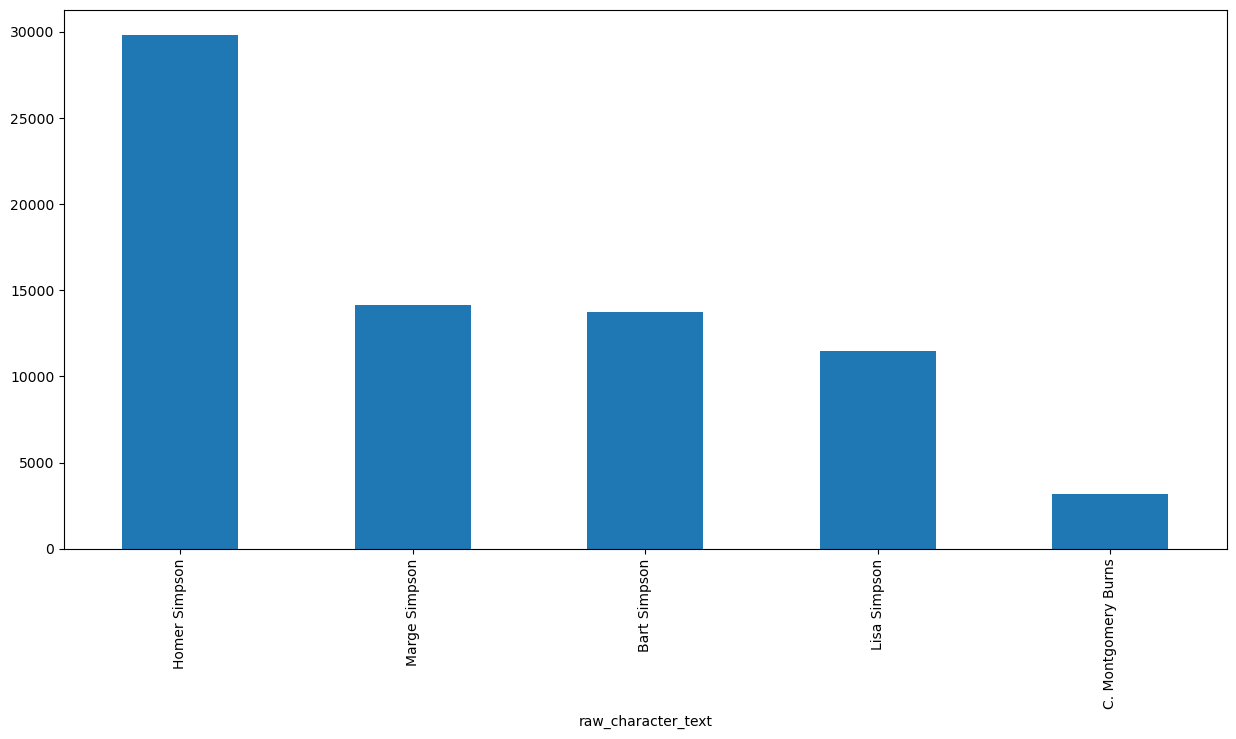

In [14]:
sep_df.raw_character_text.value_counts().plot.bar(figsize=(15,7))

In [19]:
sep_df['repeat'] = sep_df['raw_character_text'].shift(-1)
sep_df.head(3)

C:\Users\Asus\AppData\Local\Temp\ipykernel_4632\149421281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_df['repeat'] = sep_df['raw_character_text'].shift(-1)


,raw_character_text,spoken_words,repeat
1,Lisa Simpson,Where's Mr. Bergstrom?,Lisa Simpson
3,Lisa Simpson,That life is worth living.,Bart Simpson
7,Bart Simpson,Victory party under the slide!,Lisa Simpson


In [20]:
mask = sep_df['repeat'] == sep_df['raw_character_text']
sep_df = sep_df[~mask]
sep_df.reset_index(drop= True , inplace= True )
sep_df.head(3)

,raw_character_text,spoken_words,repeat
0,Lisa Simpson,That life is worth living.,Bart Simpson
1,Bart Simpson,Victory party under the slide!,Lisa Simpson
2,Lisa Simpson,"I see he touched you, too.",Bart Simpson


TF-IDF

In [21]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
nltk.download('stopwords')

from nltk.corpus import stopwords
eng_stopwords = stopwords.words("english")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Check for NaN values in the 'spoken_words' column
sep_df['spoken_words'] = sep_df['spoken_words'].fillna('')  # Replace NaN with an empty string

C:\Users\Asus\AppData\Local\Temp\ipykernel_4632\1562134416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_df['spoken_words'] = sep_df['spoken_words'].fillna('')  # Replace NaN with an empty string


In [26]:
tokenized_sentences = sep_df['spoken_words'].apply(wordpunct_tokenize)
len(tokenized_sentences)

42506

In [27]:
# vectorizer
vectorizer = TfidfVectorizer(stop_words=eng_stopwords,
                             ngram_range=(1,3),
                             max_features=5024,
                             tokenizer=wordpunct_tokenize)

In [28]:
matrix_tfidf = vectorizer.fit_transform(sep_df['raw_character_text'])
print(matrix_tfidf.shape)
print(type(matrix_tfidf))

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  warnings.warn(


(42506, 18)
<class 'scipy.sparse._csr.csr_matrix'>


In [29]:
class SimpleSearchEngine:
    def __init__(self, text_database: list[str], top_k: int):
        self.raw_procesed_data = [self.preprocess(sample) for sample in text_database]
        self.base = []
        self.retriever = None
        self.inverted_index = {}
        self._init_retriever(text_database)
        self._init_inverted_index(text_database)
        self.top_k = top_k

    @staticmethod
    def preprocess(sentence: str) -> str:
        return sentence

    def _init_retriever(self, text_database: list[str]):
        """
        TfidfVectorizer is used to convert a collection of raw documents into a
        matrix of TF-IDF features.
        Use fit_transform method of TfidfVectorizer to learn the vocabulary and
        idf from the training set and the transformed matrix.
        """
        self.retriever = TfidfVectorizer(stop_words=eng_stopwords,
                             ngram_range=(2,5),
                             max_features=5024,
                             tokenizer=wordpunct_tokenize)

        self.base = self.retriever.fit_transform(text_database) #train retriever

    def retrieve(self, query: str) -> np.array:
        return self.retriever.transform([query])

    def retrieve_documents(self, query: str, out = "best") -> np.array:
        """
        The query needs to be transformed into the same vector space as your
        document base.
        Utilize cosine_similarity to compute the similarity between the query
        vector and all document vectors in the base.
        Remember that cosine_similarity returns a matrix; you might need to
        flatten it to get a 1D array of similarity scores.
        Sort the documents based on their cosine similarity scores to find k
        most relevant ones to the query and return them as answer.
        """
        query_vector = self.retrieve(query)
        cosine_similarities = cosine_similarity(query_vector, self.base).flatten()
        if out == "best":
            relevant_indices = np.argsort(cosine_similarities, axis=0)[::-1][:self.top_k]
        elif out == "bad":
            relevant_indices = np.argsort(cosine_similarities, axis=0)[::-1][self.top_k:]
            relevant_indices = np.random.choice(relevant_indices, self.top_k, replace=False)
        return relevant_indices

    def _init_inverted_index(self, text_database: list[str]):
        self.inverted_index = dict(enumerate(text_database))

    def display_relevant_docs(self, query: str, full_database, out = "best") -> list[str]:
        docs_indexes = self.retrieve_documents(query, out = out)
        return [self.inverted_index[ind].replace('\n', "") for ind in docs_indexes]

In [31]:
simple_search_engine = SimpleSearchEngine(sep_df['spoken_words'], 3)
query = "What is the best rest?"

best_results = simple_search_engine.display_relevant_docs(query, sep_df['raw_character_text'], 'best')
print(f'best_results {best_results}')

bad_results = simple_search_engine.display_relevant_docs(query, sep_df['raw_character_text'], 'bad')
print(f'bad_results {bad_results}')

best_results ["Mr. Bergstrom, we request the pleasure of your company... no... Mr. Bergstrom, if you're not doing anything this Friday... no... Mr. Bergstrom, do you like pork chops... oh no, of course you wouldn't...", '', 'Don Rickles zinged you, Marge.']
bad_results ['But Marge, this one came with a free corncob pipe.', "Well, you can't argue with results...", 'I win! P-A-R-T. Par-tee!']


In [33]:
test_text = 'What is the best rest?'
simple_search_engine = SimpleSearchEngine(sep_df['spoken_words'], 5)
docs = simple_search_engine.retrieve_documents(test_text, 'best')
docs

array([42505, 14175, 14173, 14172, 14171], dtype=int64)

Make dataset

In [34]:
def window_back(id, win):
    if (id - win)<0:
        win = id
    return win

def window(id, win, top):
    if (id + win)> top:
        win = id
    return win

In [36]:
CON_WIND = 5 # context_window
CLOSE_REP = 4 # close_reply
TOP_K = 3 # top_k

#DF_OUT = sep_df[['Season',	'Episode']]

# инициилизируем search_engine на TF-idf
simple_search_engine = SimpleSearchEngine(sep_df['spoken_words'], TOP_K)

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  warnings.warn(


In [40]:
DF_OUT = pd.DataFrame()

In [41]:
# speaker - тот кто говорит первый
DF_OUT['speaker'] = sep_df['raw_character_text'].shift(1)

# Что говорит speaker
DF_OUT['query'] = sep_df['spoken_words'].shift(1)

# Собеседники
DF_OUT['companions'] = [sep_df.iloc[id+1:id+1 + window(id, CLOSE_REP, sep_df.shape[0])]['raw_character_text'].to_list() for id in sep_df.index]

# Ближайшие реплики собеседников
DF_OUT["close_reply"] = [sep_df.iloc[id+1:id+1 + window(id, CLOSE_REP, sep_df.shape[0])]['spoken_words'].to_list() for id in sep_df.index]

# реплики подобранные на Tf-Idf
DF_OUT["neutral_reply"] = sep_df['spoken_words'].apply(lambda query: simple_search_engine.display_relevant_docs(query, sep_df['raw_character_text'], 'best'))

# плохие реплики подобранные на Tf-Idf
DF_OUT["bad_reply"] = sep_df['spoken_words'].apply(lambda query: simple_search_engine.display_relevant_docs(query, sep_df['raw_character_text'], 'bad'))

# контекст прошлых реплик разговора
DF_OUT["context"] = ['. '.join(sep_df.iloc[id-window_back(id, CON_WIND):id ]['spoken_words'].to_list()) for id in sep_df.index]

DF_OUT.dropna(inplace=True)

In [42]:
DF_OUT.head(10)

,speaker,query,companions,close_reply,neutral_reply,bad_reply,context
1,Lisa Simpson,That life is worth living.,"[Lisa Simpson, Bart Simpson, Lisa Simpson, Hom...","[I see he touched you, too., No., So, I guess ...","[Mr. Bergstrom, we request the pleasure of you...","[Uh oh., Wow! It's a machine that makes carniv...",That life is worth living.
2,Bart Simpson,Victory party under the slide!,"[Bart Simpson, Lisa Simpson, Homer Simpson, Li...","[No., So, I guess this is it? It you don't min...","[No, not now., There, there., Me, too.]",[It's not giant and it's not in the distance! ...,That life is worth living.. Victory party unde...
3,Lisa Simpson,"I see he touched you, too.","[Lisa Simpson, Homer Simpson, Lisa Simpson, Ma...","[So, I guess this is it? It you don't mind I'l...","[Mr. Bergstrom, we request the pleasure of you...","[What are you doing, Marge? Didn't you hear th...",That life is worth living.. Victory party unde...
4,Bart Simpson,No.,"[Homer Simpson, Lisa Simpson, Marge Simpson, L...","[Bart didn't get one vote?! Oh, this is the wo...","[So, I guess this is it? It you don't mind I'l...","[Oh man, now she's writing cutesy things with ...",That life is worth living.. Victory party unde...
5,Lisa Simpson,"So, I guess this is it? It you don't mind I'll...","[Lisa Simpson, Marge Simpson, Lisa Simpson, Ho...","[Nothing., Lisa, tell your father., Mr. Bergst...","[Bart didn't get one vote?! Oh, this is the wo...",[Because sometimes the only way you can feel g...,That life is worth living.. Victory party unde...
6,Homer Simpson,"Bart didn't get one vote?! Oh, this is the wor...","[Marge Simpson, Lisa Simpson, Homer Simpson, L...","[Lisa, tell your father., Mr. Bergstrom left t...","[Nothing., Nothing should., I regret nothing.]","[, Sure! You're gonna be all ""I'm-so-stupid! I...",Victory party under the slide!. I see he touch...
7,Lisa Simpson,Nothing.,"[Lisa Simpson, Homer Simpson, Lisa Simpson, Ho...","[Mr. Bergstrom left today., Oh., He's gone. Fo...","[Lisa, tell your father., Lisa, tell your moth...","[I know, he's changed., Get in., Well, he's go...","I see he touched you, too.. No.. So, I guess t..."
8,Marge Simpson,"Lisa, tell your father.","[Homer Simpson, Lisa Simpson, Homer Simpson, L...","[Oh., He's gone. Forever., And?, I didn't thin...","[Mr. Bergstrom left today., Mr. Bergstrom!, He...",[What if we show Lisa we can sleep in her room...,"No.. So, I guess this is it? It you don't mind..."
9,Lisa Simpson,Mr. Bergstrom left today.,"[Lisa Simpson, Homer Simpson, Lisa Simpson, Ho...","[He's gone. Forever., And?, I didn't think you...","[Oh., Oh my., Oh.]","[Yeah, well you think I'm stupid., I still thi...","So, I guess this is it? It you don't mind I'll..."
10,Homer Simpson,Oh.,"[Homer Simpson, Lisa Simpson, Homer Simpson, L...","[And?, I didn't think you'd understand., Hey, ...","[He's gone. Forever., She's been gone for a wh...","[Olympic trials, eh?, Yeah, but this is me tal...","Bart didn't get one vote?! Oh, this is the wor..."


In [44]:
file_name = "talks_dataset.df"

DF_OUT.to_pickle(file_name)

In [45]:
load_df = pd.read_pickle(file_name)
load_df.sample(3)

,speaker,query,companions,close_reply,neutral_reply,bad_reply,context
37748,Homer Simpson,"Oh, right. I mean, this looks like a dress fro...","[Marge Simpson, Homer Simpson, Lisa Simpson, M...","[Oh, of course. You're right, honey. I'll just...","[Dad, I believe we were on a date., My prom da...","[Did you see that?, We can talk about that aft...",Where'd you get that dress?. Remember that sew...
27994,Bart Simpson,"Mom, what are you doing in my game?! How would...","[Bart Simpson, Homer Simpson, Lisa Simpson, Ba...","[, Hey, Lisa, self-conscious about your shins?...","[I'd like that very much., I hope the Ovenfres...","[Hey, you , you cut me off! Ah, yeah, you!, Th...",. . My son is an evil knight! The most success...
36573,Bart Simpson,The sum of the square roots of any two sides o...,"[Bart Simpson, Homer Simpson, Marge Simpson, H...","[Yes it is, they're my lines as the scarecrow ...","[That's right., That's right. No questions ask...","[Whoops! There goes Carlsbad Caverns. Oh, well...",FIND LOVE ON THE NET. YOU DESERVE WHAT YOU GET...


In [46]:
load_df.loc[3]['neutral_reply']

["Mr. Bergstrom, we request the pleasure of your company... no... Mr. Bergstrom, if you're not doing anything this Friday... no... Mr. Bergstrom, do you like pork chops... oh no, of course you wouldn't...",
 '',
 'Don Rickles zinged you, Marge.']

In [48]:
import re
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('', '', text)

def convert2several_words(text):
    new_text = ''
    for word in text.split():
        if not word.isupper():
            word = "".join((" " + w if (w.isupper() and i) else w) for i, w in enumerate(word))
            new_text+= " " + word
        else:
            new_text+=' '+word
    return ' '.join(new_text.split())

#Collect all functions
def clean_text(text):
    text = remove_between_square_brackets(text)
    text = convert2several_words(text)
    return ' '.join(text.split())  

In [49]:
sentence = load_df.sample()["context"].values[0]
print(sentence)
print()
print(clean_text(sentence))

I don't think so.. Bart, don't ask stupid questions. Is there any frontal nudity?. Homer, can you run some lines with me?. Make Bart do it.. It'll just take a sec.

I don't think so.. Bart, don't ask stupid questions. Is there any frontal nudity?. Homer, can you run some lines with me?. Make Bart do it.. It'll just take a sec.


In [50]:
train_df = load_df[["speaker"]]

In [51]:
train_df["query"] = load_df["query"].apply(clean_text)

C:\Users\Asus\AppData\Local\Temp\ipykernel_4632\890339121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["query"] = load_df["query"].apply(clean_text)


In [52]:
import random
use_col = ['speaker', 'query', 'context', "companions", "close_reply"]

train_df = load_df.iloc[:-5][use_col]

for index, row in load_df.iloc[:-5:,:].iterrows():
    train_df.loc[index]["query"] = clean_text(row["query"])
    train_df.loc[index]["context"] = clean_text(row["context"])
    id = random.randint(0, len(row["companions"]) - 1)
    train_df.loc[index]["companions"] = row["companions"][id]
    train_df.loc[index]["close_reply"] = clean_text(row["close_reply"][id])

C:\Users\Asus\AppData\Local\Temp\ipykernel_4632\3954105351.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[index]["query"] = clean_text(row["query"])
C:\Users\Asus\AppData\Local\Temp\ipykernel_4632\3954105351.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[index]["context"] = clean_text(row["context"])
C:\Users\Asus\AppData\Local\Temp\ipykernel_4632\3954105351.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [53]:
train_df.head(3)

,speaker,query,context,companions,close_reply
1,Lisa Simpson,That life is worth living.,That life is worth living.,"[Lisa Simpson, Bart Simpson, Lisa Simpson, Hom...","[I see he touched you, too., No., So, I guess ..."
2,Bart Simpson,Victory party under the slide!,That life is worth living.. Victory party unde...,"[Bart Simpson, Lisa Simpson, Homer Simpson, Li...","[No., So, I guess this is it? It you don't min..."
3,Lisa Simpson,"I see he touched you, too.",That life is worth living.. Victory party unde...,"[Lisa Simpson, Homer Simpson, Lisa Simpson, Ma...","[So, I guess this is it? It you don't mind I'l..."


In [54]:
def make_prompt(df):
    id = random.randint(0, len(df[use_col]["companions"]))
    query = df['query']
    role = df['companions']
    context = df['context']
    reply = df["close_reply"]
    prompt = f"[INST]"
    prompt += f'Use the given context to guide your an about the query like indicated in your role'
    prompt += f"query: {query}\n\n"
    prompt += f"context: {context}\n\n"
    prompt += f"your role: {role}\n\n"
    prompt += f'answer:{reply}[/INST]'
    return prompt

In [58]:
train_df["prompt"] = train_df.apply(make_prompt, axis=1)

In [59]:
print(train_df.columns)

Index(['speaker', 'query', 'context', 'companions', 'close_reply', 'prompt'], dtype='object')


In [60]:
train_df.loc[10]["prompt"]

'[INST]Use the given context to guide your an about the query like indicated in your rolequery: Oh.\n\ncontext: Bart didn\'t get one vote?! Oh, this is the worst thing that ever happened to us. Alright, allright, spilled milk, spilled milk, spilled milk. What are you so mopey about?. Nothing.. Lisa, tell your father.. Mr. Bergstrom left today.. Oh.\n\nyour role: [\'Homer Simpson\', \'Lisa Simpson\', \'Homer Simpson\', \'Lisa Simpson\']\n\nanswer:[\'And?\', "I didn\'t think you\'d understand.", "Hey, just because I don\'t care doesn\'t mean I don\'t understand.", "I\'m glad I\'m not crying because I would hate for you to think that what I\'m about to say is based on emotion. But you, sir, are a baboon!"][/INST]'

In [61]:
!pip install datasets -q


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
import datasets

In [63]:
dataset =  datasets.Dataset.from_pandas(train_df[["prompt"]] )

In [64]:
dataset[:3]

{'prompt': ['[INST]Use the given context to guide your an about the query like indicated in your rolequery: That life is worth living.\n\ncontext: That life is worth living.\n\nyour role: [\'Lisa Simpson\', \'Bart Simpson\', \'Lisa Simpson\', \'Homer Simpson\']\n\nanswer:[\'I see he touched you, too.\', \'No.\', "So, I guess this is it? It you don\'t mind I\'ll just run alongside the train as it speeds you from my life?", "Bart didn\'t get one vote?! Oh, this is the worst thing that ever happened to us. Alright, allright, spilled milk, spilled milk, spilled milk. What are you so mopey about?"][/INST]',
  '[INST]Use the given context to guide your an about the query like indicated in your rolequery: Victory party under the slide!\n\ncontext: That life is worth living.. Victory party under the slide!\n\nyour role: [\'Bart Simpson\', \'Lisa Simpson\', \'Homer Simpson\', \'Lisa Simpson\']\n\nanswer:[\'No.\', "So, I guess this is it? It you don\'t mind I\'ll just run alongside the train as 

In [65]:
file_name = "sp_dataset.hf"

dataset.save_to_disk(file_name)

Saving the dataset (0/1 shards):   0%|          | 0/42500 [00:00<?, ? examples/s]

In [66]:
loaded = datasets.load_from_disk(file_name)

In [67]:
loaded[:10]

{'prompt': ['[INST]Use the given context to guide your an about the query like indicated in your rolequery: That life is worth living.\n\ncontext: That life is worth living.\n\nyour role: [\'Lisa Simpson\', \'Bart Simpson\', \'Lisa Simpson\', \'Homer Simpson\']\n\nanswer:[\'I see he touched you, too.\', \'No.\', "So, I guess this is it? It you don\'t mind I\'ll just run alongside the train as it speeds you from my life?", "Bart didn\'t get one vote?! Oh, this is the worst thing that ever happened to us. Alright, allright, spilled milk, spilled milk, spilled milk. What are you so mopey about?"][/INST]',
  '[INST]Use the given context to guide your an about the query like indicated in your rolequery: Victory party under the slide!\n\ncontext: That life is worth living.. Victory party under the slide!\n\nyour role: [\'Bart Simpson\', \'Lisa Simpson\', \'Homer Simpson\', \'Lisa Simpson\']\n\nanswer:[\'No.\', "So, I guess this is it? It you don\'t mind I\'ll just run alongside the train as 